# <p style="text-align:center;">Redes Neunorales Recurrentes</p>
## <p style="text-align:center;">José Luis Sosa Arenas</p>
### <p style="text-align:center;">Diplomado en Ciencia de Datos</p>
#### <p style="text-align:center;">Módulo 6</p>
##### <p style="text-align:center;">Modelo LSTM (Long Short-term Memory)</p>
###### <p style="text-align:center;">luissosaare@gmail.com</p>

### **Ejercicio**: Predicción del rendimiento estudiantil. Un conjunto de datos tabulares que contiene datos sobre el rendimiento de los estudiantes, incluidos los hábitos de estudio, la asistencia y los puntajes de los exámenes finales.

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import seaborn as sns

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style

# Preprocesado y modelado
# ==============================================================================
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Lectura de la base de datos
data = pd.read_csv("student_performance_dataset.csv")
data.head()

,Student_ID,Gender,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Parental_Education_Level,Internet_Access_at_Home,Extracurricular_Activities,Final_Exam_Score,Pass_Fail
0,S147,Male,31,68.267841,86,High School,Yes,Yes,63,Pass
1,S136,Male,16,78.222927,73,PhD,No,No,50,Fail
2,S209,Female,21,87.525096,74,PhD,Yes,No,55,Fail
3,S458,Female,27,92.076483,99,Bachelors,No,No,65,Pass
4,S078,Female,37,98.655517,63,Masters,No,Yes,70,Pass


In [5]:
#Sustituimos valores en las columnas "Internet_Access_at_home" y "Extracurricular_Activities#
#Los valores Yes se sustituyen por 1 y los No se sustituyen por 0
data['Internet_Access_at_Home'] =  data['Internet_Access_at_Home'].str.replace('Yes', '1')
data['Internet_Access_at_Home'] =  data['Internet_Access_at_Home'].str.replace('No', '0')

data['Extracurricular_Activities'] =  data['Extracurricular_Activities'].str.replace('Yes', '1')
data['Extracurricular_Activities'] =  data['Extracurricular_Activities'].str.replace('No', '0')

#De igual manera en la columna 'Pass_Fail' cambiamos los valores 'Pass' por 1 y 'Fail' por 0
data['Pass_Fail'] =  data['Pass_Fail'].str.replace('Pass', '1')
data['Pass_Fail'] =  data['Pass_Fail'].str.replace('Fail', '0'
                                                  )
data.head()

,Student_ID,Gender,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Parental_Education_Level,Internet_Access_at_Home,Extracurricular_Activities,Final_Exam_Score,Pass_Fail
0,S147,Male,31,68.267841,86,High School,1,1,63,1
1,S136,Male,16,78.222927,73,PhD,0,0,50,0
2,S209,Female,21,87.525096,74,PhD,1,0,55,0
3,S458,Female,27,92.076483,99,Bachelors,0,0,65,1
4,S078,Female,37,98.655517,63,Masters,0,1,70,1


In [6]:
#Eliminamos la columna 'Student_ID', 'Gender' y 'Parental_Education_Level' ya que no se consideran importantes para el análisis
data = data.drop (['Student_ID', 'Gender', 'Parental_Education_Level'] ,axis = 1)
data.head()

,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Internet_Access_at_Home,Extracurricular_Activities,Final_Exam_Score,Pass_Fail
0,31,68.267841,86,1,1,63,1
1,16,78.222927,73,0,0,50,0
2,21,87.525096,74,1,0,55,0
3,27,92.076483,99,0,0,65,1
4,37,98.655517,63,0,1,70,1


In [7]:
data.shape

(708, 7)

In [8]:
data.isna().sum()

Study_Hours_per_Week          0
Attendance_Rate               0
Past_Exam_Scores              0
Internet_Access_at_Home       0
Extracurricular_Activities    0
Final_Exam_Score              0
Pass_Fail                     0
dtype: int64

<Axes: >

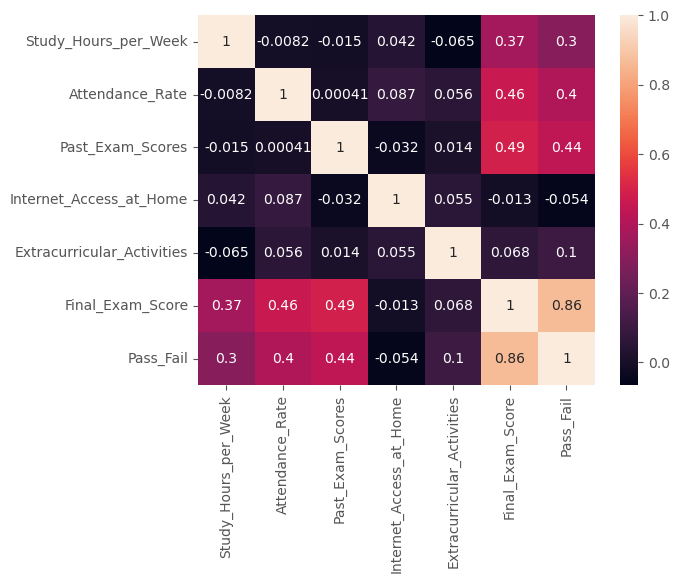

In [9]:
#Observamos el mapa de calor para deducir variables de correlación
sns.heatmap(data.corr(), annot= True)

In [10]:
#Creamos una muestra del 10% del data original para tomarlos como datos de entrenamiento
train_data = data.sample(n=70).copy()
train_data.head()

,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Internet_Access_at_Home,Extracurricular_Activities,Final_Exam_Score,Pass_Fail
643,33,95.775684,89,1,0,69,1
293,23,85.702960,98,0,0,60,1
562,11,73.658310,76,1,1,54,0
560,29,74.041849,90,0,1,62,1
131,28,90.037489,78,1,0,67,1


In [11]:
# Cargar los datos de entrenamiento
train_data_or = train_data[train_data['Final_Exam_Score'] == 70][['Study_Hours_per_Week', 
                                                         'Attendance_Rate',
                                                         'Past_Exam_Scores']]

In [18]:
def preprocess_data(train_data):
    # Convertir la columna de pasajeros en un array numpy
    arr = train_data['Final_Exam_Score'].values.astype(float)
    arr = arr.reshape(-1, 1)

    # Normalización de datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    arr_scaled = scaler.fit_transform(arr)

    # Crear secuencias de entrenamiento
    sequence_length = 10  # Número de pasos de tiempo considerados
    X, y = [], []
    for i in range(len(arr_scaled) - sequence_length):
        X.append(arr_scaled[i:i+sequence_length])
        y.append(arr_scaled[i+sequence_length])

    return np.array(X), np.array(y), scaler

X, y, scaler = preprocess_data((train_data))

In [19]:
# Separar datos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [20]:
# Modelo LSTM
model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),  #return_sequences=True Devuelve salidas para cada paso (necesario para apilar LSTM)
    Dropout(0.2), #evita el sobreajuste , apaga aleatoriamete el 20% de las neuronas durante el entrenamiento#
    LSTM(70, return_sequences=False), #return sequences = False nos da la salid final y no toda la secuencia
    Dense(1) #capa final densa
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 70)              │          20,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 70)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 70)                  │          39,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              71 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,711 (233.25 KB)

 Trainable params: 59,711 (233.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.2711
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1163 
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0915 
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0881 
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0860
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0955 
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0897
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0972 
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0917
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0915
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0859 
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0909
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0944
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0873
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0844 
Epoch 16/50
2/2 ━━━━━━━━━━━

In [ ]:
# Preparar los datos reales para comparación
real_data = data
real_data = real_data_2024[['Study_Hours_per_Week', 'Attendance_Rate', 'Past_Exam_Scores']]
real_data = pd.DataFrame(SimpleImputer.transform(real_data), columns=real_data.columns, index=real_data.index)
real_scaled = scaler.transform(real_data)

In [ ]:
# Crear datos de entrada para predicción
X_real, _ = create_dataset(np.vstack([train_scaled[-60:], real_scaled]), 60)

# Predicciones
predictions_scaled = model.predict(X_real)
predictions = scaler.inverse_transform(np.concatenate([predictions_scaled, np.zeros((len(predictions_scaled), 2))], axis=1))[:, 0]

# Datos reales para comparar
real_demand = scaler.inverse_transform(real_scaled)[:, 0]

In [ ]:
# Asegurarse de que tanto 'real_demand' como 'predictions' tienen el mismo índice de tiempo
real_demand = pd.Series(real_demand[:len(predictions)], index=real_data_2024.index[:len(predictions)])
predictions_series = pd.Series(predictions, index=real_data_2024.index[:len(predictions)])

# Crear una lista para almacenar los R-squared de cada mes
r_squared_monthly = []

# Agrupar los datos por mes y calcular el R-squared para cada mes
for month, group in real_demand.groupby(real_demand.index.month):
    # Extraer las predicciones correspondientes para ese mes
    pred_for_month = predictions_series[group.index]
    
    # Calcular el R-squared
    r_squared = r2_score(group, pred_for_month)
    
    # Almacenar el resultado
    r_squared_monthly.append((month, r_squared))
    print(f'R-squared para el mes {month}: {r_squared}')

# Crear la figura usando Plotly para una mejor interactividad y presentación
fig = go.Figure()

# Añadir los datos reales a la gráfica
fig.add_trace(go.Scatter(x=real_data.index, y=real_demand, mode='lines', name='Datos Reales', line=dict(color='blue')))

# Añadir las predicciones a la gráfica
fig.add_trace(go.Scatter(x=real_data.index[:len(predictions)], y=predictions, mode='lines', name='Predicciones Futuras', line=dict(color='red')))

# Configuración adicional del gráfico
fig.update_layout(
    title='Comparación de Predicciones vs Datos Reales',
    xaxis_title='Fecha',
    yaxis_title='Estimación de Final_Exam_Score',
    legend_title='Leyenda'
)

# Mostrar la gráfica
fig.show()

# Imprimir los R-squared mensuales
for month, r_squared in r_squared_monthly:
    print(f"R-squared para el mes {month}: {r_squared:.4f}")